E — Inpainting без ручного рисования маски (удаление объекта/замена фона)

In [1]:
!pip install -q diffusers==0.30.3 transformers==4.45.2 accelerate==0.34.2 safetensors==0.4.5 pillow ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 65.1 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageDraw
from IPython.display import display
from google.colab import files
import numpy as np
import os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------
# 2) Загрузка inpaint-пайплайна
# -------------------
model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, dtype=torch.float16)
pipe = pipe.to(device)
# -------------------


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Загрузите файл (напр., фото с объектом для удаления):


Saving sbk.jpg to sbk.jpg


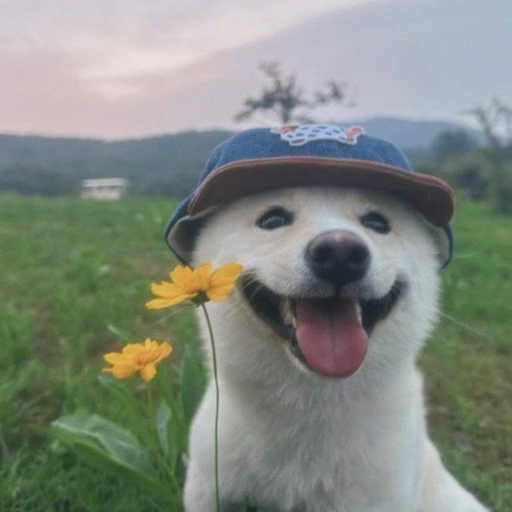

In [4]:
# 3) Загрузка изображения (Colab -> файл)
# -------------------
print("Загрузите файл (напр., фото с объектом для удаления):")
uploaded = files.upload()  # Colab-диалог
img_path = list(uploaded.keys())[0]
orig = Image.open(img_path).convert("RGB")
display(orig.resize((512,512)))
# -------------------


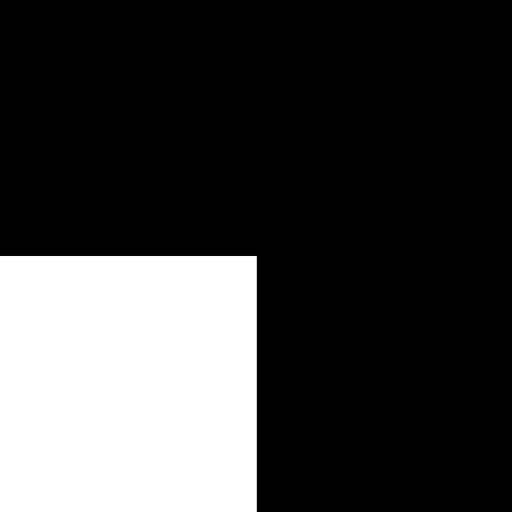

In [12]:
# 4) Вариант A: авто bbox (удаляем прямоугольник в центре, ученик может поменять coords)
# -------------------
w, h = orig.size

# Координаты левой нижней четверти
x1 = 0
y1 = h // 2        # нижняя половина начинается здесь
x2 = w // 2        # левая половина заканчивается здесь
y2 = h             # до самого низа

# Создаём маску: ЧЁРНЫЙ фон = "ничего не трогать"
mask = Image.new("RGB", (w, h), color=(0, 0, 0))  # ← КЛЮЧЕВОЕ ИЗМЕНЕНИЕ!
draw = ImageDraw.Draw(mask)

# БЕЛЫМ закрашиваем область, которую хотим заменить
draw.rectangle([x1, y1, x2, y2], fill=(255, 255, 255))

display(mask.resize((512,512)))

In [13]:
# 5) Inpaint: описание замены (пример: заменить предмет фона на "sunset over mountains")
# -------------------
prompt = "remove yellow flowers"
# Параметры: strength/steps не используются в inpaint; используем guidance и steps
result = pipe(prompt=prompt, image=orig, mask_image=mask, guidance_scale=7.5, num_inference_steps=30)
out_img = result.images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

Исходное (слева)  —  Результат Inpainting (справа)


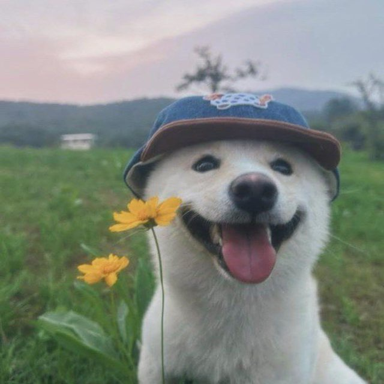

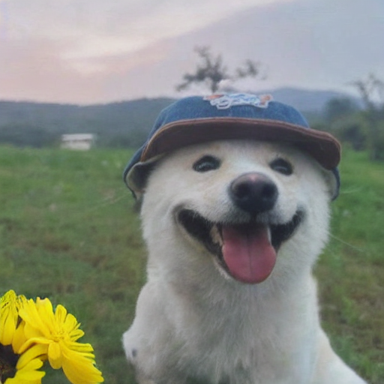

In [14]:
# 6) Показ "до / после"
# -------------------
print("Исходное (слева)  —  Результат Inpainting (справа)")
display(orig.resize((384,384)))
display(out_img.resize((384,384)))
# Сохраним
out_img.save("/content/inpaint_result.png")